# PCSE classification for mussel growth sites

In [21]:
# Region classification
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import hmean
from math import isnan # a bit faster than numpy
from xarray import open_dataset
from pandas import read_excel, DataFrame

# Georeferenced plotting
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from scalebar import scale_bar #Imported code from the internet
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


Load files and extract variables

In [2]:
file = 'Result_PCSE_STD.pickle'
with open(file, 'rb') as openfile:
    data = pickle.load(openfile)

var = list(data.keys())
years = list(data[var[0]])

In [3]:
# Bathymetry file
bat = open_dataset(r'bathymetry.nc')

### Solving von Bertalanffy growth for time to a specific length

$$L = L_{\infty} - (L_{\infty} - L_b) e^{-r_B t}$$

$$ L - L_{\infty} = (-L_{\infty} + L_b) e^{-r_B t} $$

$$\ln{\frac{L - L_{\infty}}{-L_{\infty}+L_b}} = -r_bt $$

$$t = \frac{\ln{\frac{L - L_{\infty}}{L_b - L_{\infty}}}}{-r_b} $$


$$t =\ln{\frac{L_b - L_{\infty}}{L - L_{\infty}}}r_b^{-1} $$



*HENRIQUES, M., Aspects of the population structure of the brown mussel, Perna perna, related to the extraction from natural beds, of Santos Bay, State of São Paulo, Brazil. Boletim do Instituto de Pesca, 30, pp.117-126.* Shows that minimum marketable length is **5 cm.**

In [4]:
def t2L(L, L_i, r_B, L_0=0):
    """Returns time to length for von Bertalanffy growth function"""
    return (np.log((L_0 - L_i)/(L-L_i))/r_B)

### If time is negative:

It is because $\ln\frac{L_b - L_i}{L - L_i}$ is negative. That will only be true for $\frac{L_b - L_i}{L - L_i} < 1$. Since $L_b$ is a constant (= 0) in this study, and $L_i$ is always positive, our numerator will always be negative. The denominator is also always supposed to be negative (so the fraction is positive, allowing a ln calculation), but it can be positive if $ L_i < L$. If that is the case, the region does not provide enough resources for the mussel to reach commercial size, so it is undefined for these regions. 

In [5]:
vars_int = ['r_B', 'L_i']  # variables of interest

t = 240                    # days, 8 months of growth
init_size = 0              # cm, initial size for growth (30 mm)
market_size = 5            # cm, accepted marketable size in Brazil

PCSE_class = dict()


for year in years:
    li_array, rb_array = data['L_i'][year], data['r_B'][year]
    PCSE_class[year] = np.empty(np.shape(data['L_i']['2002']), dtype=float) # initialize empty 2d-array with right dimensions
    
    for i, li in np.ndenumerate(li_array):
        rb = rb_array[i]
        t2marketsize = t2L(market_size, li, rb, init_size)
        
        if isnan(li) or isnan(rb) or t2marketsize < 0 or t2marketsize > 365:
            PCSE_class[year][i] = np.inf
      
        else:
            PCSE_class[year][i] = t2marketsize / 30 # days to months (easier to read)


<ipython-input-4-1bc471478ab1>:3: RuntimeWarning: invalid value encountered in log
  return (np.log((L_0 - L_i)/(L-L_i))/r_B)


In [6]:
# Confirm maximum and minimum of classified data

for year in years:
    print(np.nanmin(PCSE_class[year]), np.nanmax(PCSE_class[year][PCSE_class[year]< np.inf]))

1.765692436951855 12.165489909548295
2.065986606489249 12.166417822722734
1.8916428414672706 12.165248120211727
1.6555932050356932 12.15926756059733
1.8119572361795195 12.121132399612199
2.008517699956884 12.158319723883212
1.8874555445186099 12.146267678877502
1.7542817083671645 12.157966338353265
1.7539308784156948 12.162339123239155
2.296991374675757 12.142513123436972
1.6422293454392332 12.16495389967289
1.6581105724245395 12.165392456466808
2.0221815586962784 12.161517252815806
1.6713165218646715 12.165640732704754
1.9364563641278243 12.156318775680413
1.6257866651791193 12.143695548700082
1.6801022984781584 12.150059703124318
1.7672698340585613 12.16377611048691
1.678191031684436 12.124008855415527


In [7]:
# Obtaining central values for all years in the data

prod = PCSE_class

years = prod.keys()
meanprod = np.zeros(np.shape(prod['2002']))

for year in years:
    meanprod = np.dstack((meanprod,prod[year]))
    
meanprod = np.delete(meanprod, 0, 2) # Remove first layer of zeros  
meanprod[np.isnan(meanprod)] = np.inf # clear possible residual nan's

mean = np.nanmean(meanprod, axis=2)
median = np.nanmedian(meanprod, axis=2)
maximum = np.nanmax(meanprod, axis=2)
minimum = np.nanmin(meanprod, axis=2)
harmonic = hmean(meanprod, axis=2) # harmonic mean

In [8]:
# # Save model ouput
# data['Result'] = {}
# 
# data['Result']['PCSE_time2market_yearly'] = PCSE_class
# data['Result']['PCSE_time2market_mean'] = mean
# data['Result']['PCSE_time2market_median'] = median
# data['Result']['PCSE_time2market_max'] = maximum
# data['Result']['PCSE_time2market_min'] = minimum
# data['Result']['PCSE_time2market_harm'] = harmonic
# 
# with open('ResultFinal_PCSE_STD.pickle', 'wb') as f:
#     pickle.dump(data, f)

## Visualize results

In [9]:
def locpixel(latlon, latstr, lonstr):
    """
    Locate the pixel index from geographic coordinates.
    
    Args:
     - latlon = list with [latitude, longitude] of interest
     - latstr = list of latitudes from data
     - lonstr = list of longitude from data
    
    Returns:
     - (latitute index, longitude index)
    
    """

    ploc_lat = np.append(latstr, latlon[0])
    ploc_lat.sort(); #ploc_lat = np.flip(ploc_lat)
    ploc_lon = np.append(lonstr, latlon[1])
    ploc_lon.sort(); #ploc_lon = np.flip(ploc_lon)
    plat_i = np.array(len(latstr))-np.where(ploc_lat == latlon[0]) #Had to correct Lat to get real values
    plon_i = np.where(ploc_lon == latlon[1])

    return (int(plat_i[0]), int(plon_i[0]))

In [10]:
# Arbitrary choice of locations
coord_ilhamel_norte = [-25.495579, -48.206305]
coord_ilhamel_sul = [-25.511918, -48.358450]

ilhamel_norte = locpixel(coord_ilhamel_norte, data['lat'], data['lon'])
ilhamel_sul = locpixel(coord_ilhamel_sul, data['lat'], data['lon'])

Text(0.5, 1.0, 'Crescimento de mexilhões na Ilha do Mel - Paraná')

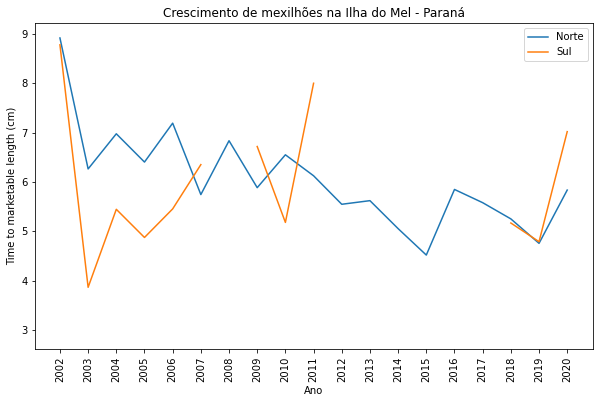

In [11]:
# How does a certain region perform throughout the years

plt.figure(figsize=(10, 6))
plt.plot(meanprod[ilhamel_norte])
plt.plot(meanprod[ilhamel_sul])
plt.xticks(range(len(meanprod[ilhamel_norte])), years, rotation='vertical')
plt.xlabel('Ano')
plt.ylabel('Time to marketable length (cm)')
plt.legend(['Norte', 'Sul'])
plt.title('Crescimento de mexilhões na Ilha do Mel - Paraná')
# plt.savefig('Paranaguá.png', facecolor='white')

## Plot median on map

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load better resolution brazilian coastline shapefile
arquivo = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
# bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
parser = shpreader.Reader(arquivo)

lat = np.array(data['lat'])
lon = np.array(data['lon'])

bat_lon, bat_lat, bathym = np.array(bat.lon), np.array(bat.lat), np.array(bat.elevation)

In [13]:
# Location points
locs = read_excel('Data_DiscussionSites.xlsx')
p_names = list(locs.Point)
p_lat = list(locs.Lat)
p_lon = list(locs.Lon)
p_lat = [float(p_lat[s].replace('°', '')) for s in range(len(p_lat))]
p_lon = [float(p_lon[s].replace('°', '')) for s in range(len(p_lon))]

/opt/anaconda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


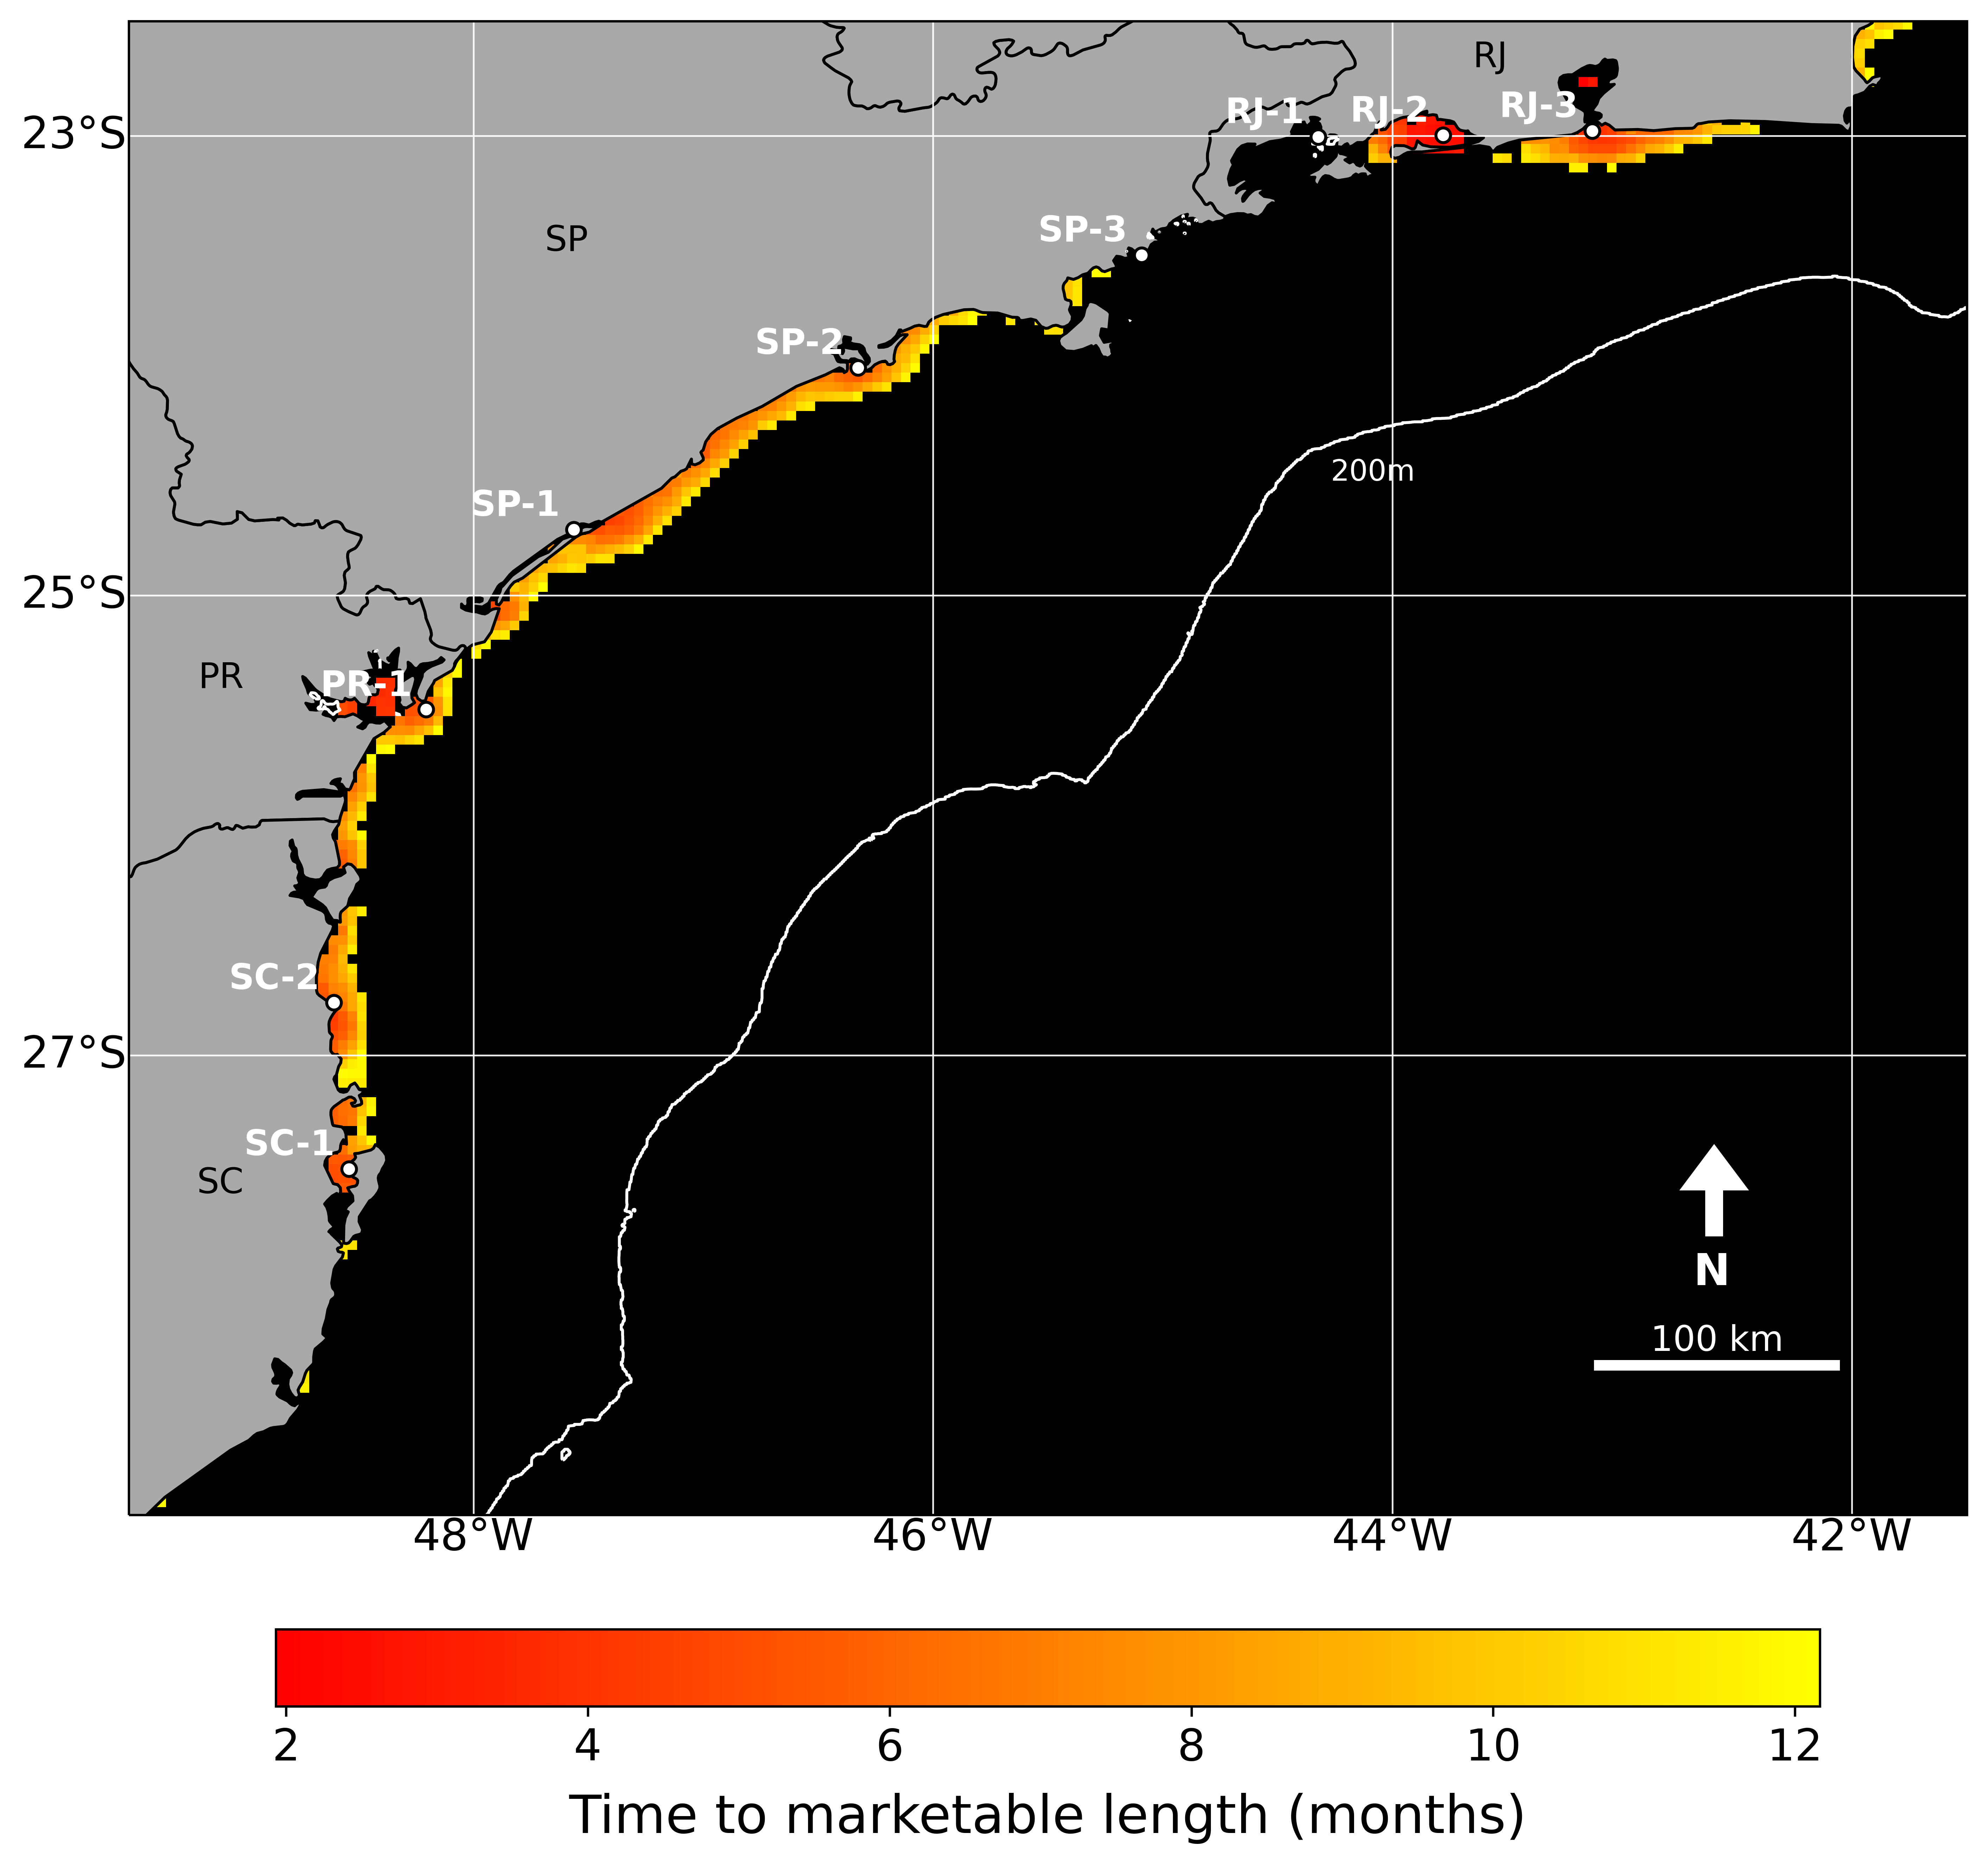

In [14]:
# Set variable to plot
t2marketlength = median
 

### Start the plotting for time to market length
paises = parser.records()
fig=plt.figure(figsize=(10, 10), dpi=600)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, facecolor = 'k')
ax.add_feature(cfeature.LAND, facecolor = 'k')
# ax.add_feature(bathym, facecolor='none', edgecolor='white', linewidth=1) # linestyle='dashed', 

extent = [-49.5, -41.5, -29, -22.5]
ax.set_extent(extent)

for estado in paises:
    if estado.attributes['admin'] == 'Brazil':        
        ax.add_geometries([estado.geometry], ccrs.PlateCarree(), facecolor='darkgray', edgecolor='k')
                          
# Plotting location points
for i in range(len(p_lat)):
    plt.plot(p_lon[i], p_lat[i],  markersize=5, marker='o', color='white', markeredgecolor='k')
    plt.text(p_lon[i]-.06, p_lat[i]+.06, locs.Point[i], horizontalalignment='right', transform=ccrs.PlateCarree(), 
         size='large', color='white', weight='bold')    

# Setting up gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='white', alpha=0.9)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-52, -50, -48, -46, -44, -42, -40, -38])
gl.ylocator = mticker.FixedLocator([-21, -23, -25, -27, -29, -31])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# State name labels
plt.text(-43.5, -22.7, 'RJ', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         size='large', color='k')
plt.text(-47.5, -23.5, 'SP', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         size='large', color='k')
plt.text(-49, -25.4, 'PR', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         size='large', color='k')
plt.text(-49, -27.6, 'SC', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         size='large', color='k')

# Set scale bar (using scalebar.py, not cartopy)
text_kwargs = dict(size='large')
plot_kwargs = dict(linewidth=3.6)
scale_bar(ax, (0.8, 0.1), 100, text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, color='white')

# North arrow
plt.arrow(-42.6, -27.75, 0, 0.2, linewidth=6, head_width=0.15, head_length=0.1, 
          fc='white', ec='white', transform=ccrs.PlateCarree())
plt.text(-42.53, -28, 'N', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         fontsize = 15, weight='bold', color='white')

# Plot time to marketable length
plt.imshow(t2marketlength, cmap='autumn', extent = (min(lon), max(lon), min(lat), max(lat)), 
           transform=ccrs.PlateCarree())#, vmin = 3)

# plt.contourf(lon, lat, t2marketlength, cmap = 'autumn', levels=np.linspace(5, 12, 8),
#            transform=ccrs.PlateCarree(), vmin = 5)

cbar = plt.colorbar(ax=ax, orientation="horizontal", shrink=.84, pad=.06) #ticks=range(9)
cbar.set_label('Time to marketable length (months)', fontsize = 18, labelpad = 8)
cbar.ax.tick_params(labelsize=15) 

# Bathymetry
plt.contour(bat_lon, bat_lat, bathym, cmap = 'gray', levels=[-6000, -200],
           transform=ccrs.PlateCarree(), linewidths=1)
plt.text(-43.9, -24.5, '200m', horizontalalignment='right', transform=ccrs.PlateCarree(), 
         fontsize = 10, color='white')

fig.canvas.draw()
plt.tight_layout(pad=3.55)

# plt.savefig('Plot_MedianTime2MarketLength.tiff', dpi = 600, facecolor='white')
# plt.savefig('Plot_MedianTime2MarketLength.png', dpi = 600, facecolor='white')

In [69]:
location = [locpixel(point, data['lat'], data['lon']) for point in zip(p_lat, p_lon)]
production_df = DataFrame()
for i in range(len(location)):
    production_df[p_names[i]] = meanprod[location[i]]
production_df['year'] = list(years)
production_df.set_index('year', inplace=True)
production_df.replace(np.inf, np.nan, inplace=True)

In [70]:
production_df

,SC-1,SC-2,PR-1,SP-1,SP-2,SP-3,RJ-1,RJ-2,RJ-3
year,,,,,,,,,
2002,6.632130,6.251073,8.922357,10.261259,10.849826,NaN,NaN,3.037745,5.818753
2003,5.401809,11.010574,6.264905,6.931308,6.159185,NaN,NaN,3.047787,4.646782
2004,6.352611,9.110414,6.977950,7.497350,6.060228,NaN,NaN,2.848019,5.290569
2005,5.770697,7.624179,6.404139,8.444918,7.165694,NaN,NaN,3.210045,3.782880
2006,5.621404,8.291317,7.193695,7.230840,5.253829,NaN,NaN,3.167119,5.020506
2007,4.981572,6.653594,5.744454,10.184237,8.376596,NaN,NaN,2.683100,4.737284
2008,5.383325,8.038058,6.837143,8.996310,10.869659,NaN,NaN,2.608113,3.763068
2009,4.767994,6.141445,5.884635,5.932377,5.106919,NaN,NaN,2.242129,3.727358
2010,5.646269,7.931609,6.551719,7.413407,11.333880,NaN,NaN,2.467697,4.082538


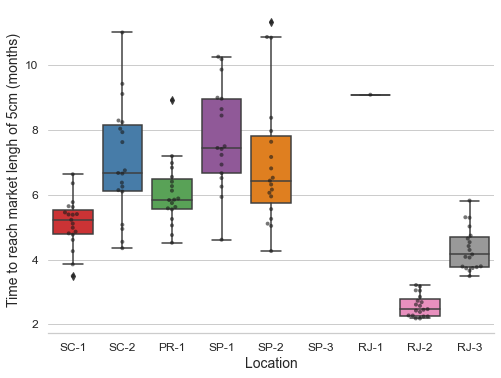

In [106]:
plt.figure(figsize=(8,6))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="whitegrid", rc=custom_params)
sns.boxplot(data=production_df, palette='Set1')#, dropna=True)
sns.swarmplot(data=production_df, color='k', alpha=.6, size=4)
sns.despine(left=True)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Location', size=14)
plt.ylabel('Time to reach market lengh of 5cm (months)', size=14)
plt.savefig('Plot_ProductionbyRegion.png', dpi = 600, facecolor='white')
plt.savefig('Plot_ProductionbyRegion.tiff', dpi = 600, facecolor='white')